# Final report for Computational Social Science 

#### Author: `Oleksandr Korniienko`


This report contains analysis of russian propaganda dataset collected from the set of telegram channels.

# Load & prepare data (cold start)

In [125]:
import json
import pandas as pd
import numpy as np
import plotly.express as px
pd.set_option('max_colwidth', 100)

import matplotlib.pyplot as plt

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords

import plotly.io as pio
pio.renderers.default = 'iframe_connected'
# pio.renderers.default = 'png'


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/oleksandrkorniienko/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/oleksandrkorniienko/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [126]:
### Define helpers

import re

def parse_reactions(input_string):
    if isinstance(input_string, float):
        return []
    pattern = r"ReactionCount\(reaction='(.*?)', count=(\d+), chosen=(True|False)\)"
    matches = re.findall(pattern, input_string)
    result_dict_list = [{'reaction': match[0], 'count': int(match[1]), 'chosen': match[2] == 'True'} for match in matches]
    return result_dict_list

def parse_id(input_string):
    if isinstance(input_string, float):
        return None
    pattern = r"PeerChannel\(channel_id=(\d+)\)"
    matches = re.findall(pattern, input_string)
    if matches:
        return matches[0]
    else:
        return None

In [205]:
### Load data & basic data extraction

df_channels = pd.read_json('../channels_list.json')

df = []
for index, row in df_channels.iterrows():
    _df = pd.read_csv(f'../channels/{row.names}.csv')
    _df['channel'] = row.names
    df.append(_df)
df = pd.concat(df)
df['datetime'] = pd.to_datetime(df['date'])
df['message_len'] = df.message.map(lambda x: len(x) if isinstance(x, str) else 0)

df['reactions_dict'] = df.reactions.map(parse_reactions)
df['reactions_num'] = df['reactions_dict'].map(lambda x: sum(map(lambda y: y['count'], x)))
df['_from_id'] = df.fwd_from.map(parse_id)
df['_to_id'] = df.to_id.map(parse_id)

KeyboardInterrupt: 

In [ ]:
### Classify input data for sensitive topics and toxicity

from tqdm import tqdm
import torch
import numpy as np
from transformers import BertTokenizer, BertForSequenceClassification

import urllib.request, json 

def classify(model_name, labels_map, messages_iterator, batch_size=64):    
    def infer(model, tokenizer, labels_map, texts):
        tokenized = tokenizer.batch_encode_plus(texts, max_length = 128, pad_to_max_length=True, truncation=True, return_token_type_ids=False)
        tokens_ids,mask = torch.tensor(tokenized['input_ids']).to('cuda') ,torch.tensor(tokenized['attention_mask']).to('cuda')
        
        with torch.no_grad():
            model_output = model(tokens_ids,mask)
        outputs = model_output['logits'].cpu().numpy().argmax(axis=1)
        
        predictions = []
        for b in range(len(outputs)):
            label = labels_map.get(str(outputs[b]), "none")
            predictions.append(label)
        return predictions

    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = BertForSequenceClassification.from_pretrained(model_name).to('cuda').half()
    model.eval()

    batch = []
    labels = []
    for msg in tqdm(messages_iterator):
        if not msg or not isinstance(msg, str):
            msg = ""
        batch.append(msg)
        
        if len(batch) == batch_size:
            labels.extend(infer(model, tokenizer, labels_map, batch))
            batch = []
    labels.extend(infer(model, tokenizer, labels_map, batch))
    return labels


### Sensitive topic extraction

In [ ]:
with urllib.request.urlopen("https://raw.githubusercontent.com/s-nlp/inappropriate-sensitive-topics/main/Version2/sensitive_topics/id2topic.json") as url:
    target_vaiables_id2topic_dict = json.load(url)

model_name = 'apanc/russian-sensitive-topics'

predictions = classify(model_name, target_vaiables_id2topic_dict, df.message.tolist(), batch_size=256)
df['sensitive-topic'] = predictions

### Toxicity extraction

In [ ]:
model_name = 'SkolkovoInstitute/russian_toxicity_classifier'
label_map = {
    '0': "neutral",
    '1': "toxic"
}
predictions = classify(model_name, label_map, df.message.tolist(), batch_size=256)

df['toxicity'] = predictions

### Store preprocessed data

In [ ]:
df.to_csv('data.csv', index=False)

### Restore preprocessed data

In [2]:
df = pd.read_csv('data.csv')
df['reactions_dict'] = df['reactions_dict'].map(json.loads)

/var/folders/xr/332bhp3x7wv7_by6ln1px4tm0000gp/T/ipykernel_78780/3016401530.py:1: DtypeWarning:

Columns (4,6,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
df['datetime'] = pd.to_datetime(df['date'])

In [4]:
df['mid'] = range(len(df))

In [5]:
df.sample()

Unnamed: 0       id                       date    views reactions  \
960426       22706  42069.0  2022-02-15 08:13:45+00:00  25334.0       NaN   

                                     to_id fwd_from  \
960426  PeerChannel(channel_id=1099860397)      NaN   

                                                                                                    message  \
960426  Вооруженные силы России завершили несколько учений, подразделения будут возвращены в пункты пост...   

        type  duration  ... msg_entity                  datetime message_len  \
960426  text       NaN  ...        NaN 2022-02-15 08:13:45+00:00         144   

       reactions_dict reactions_num  _from_id      _to_id  sensitive-topic  \
960426             []             0       NaN  1099860397         politics   

        toxicity     mid  
960426   neutral  960426  

[1 rows x 23 columns]

In [124]:
len(df.channel.unique())

299

# Data exploration

### Message types

In [127]:
fig = px.pie(df.sample(10000), names='type', title='Distribution of message types in dataset')
fig.show()

84.1% of all messages contains text or photos. ~15.7% are mostly videos, other are stikers or voice messages.

### Message number per channel

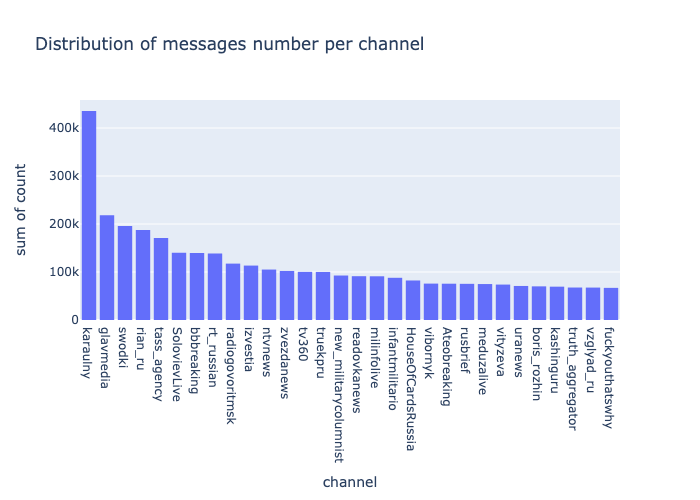

In [19]:
_df = df.value_counts('channel').reset_index()
_df.columns = ['channel', 'count']
fig = px.histogram(_df.head(30), x='channel', y='count', title='Distribution of messages number per channel')
fig.show()


The most active channel is karaulny; glavmedia and other news channels have mostly the same number of messages for the investigated period from 2015-09-22 to 2022-12-26.

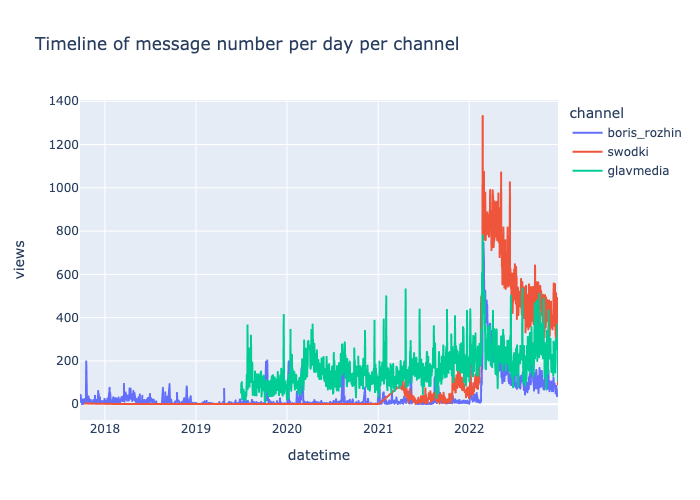

In [20]:
_df = df.groupby([df.datetime.dt.strftime('%Y-%m-%d'), 'channel'])['views'].count().reset_index()
_df = _df[(_df['views']>0)&(_df['channel'].isin(['swodki', 'boris_rozhin', 'glavmedia']))]

fig = px.line(_df, x="datetime", y="views", color='channel', log_y=False, title='Timeline of message number per day per channel')
fig.show()

There are a few abnormal number of messages per channel for 24 Feb 2022 from:
- swodki
- bosis rozhin
- glavmedia

These channels considered the sources for news about the war during the first days.

Also this metric shows abnormal messages count per channel (peaks with number of 500! messages per day).

Message numnbers per channel also has clearly visible seasonality trend with duration of one week.

### Distribution of message viewes in data

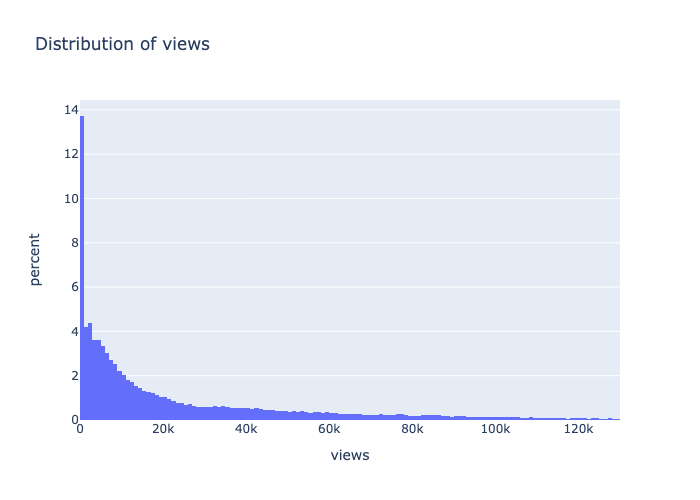

In [23]:
fig = px.histogram(df.sample(100000), histnorm='percent', nbins=5000, x="views", title='Distribution of views')
fig.update_xaxes(range=[0, 130000], row=1, col=1)
fig.show()

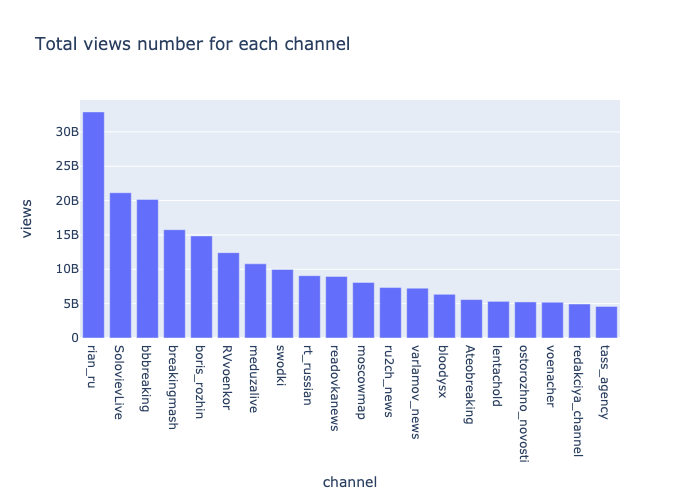

In [27]:
_df = df.groupby('channel')['views'].sum().reset_index().sort_values('views', ascending=False)
fig = px.bar(_df.head(20), x='channel', y='views', title='Total views number for each channel')
fig.show()

The most viewed channel is rian_ru, the next is solovievlive and bbbreaking.

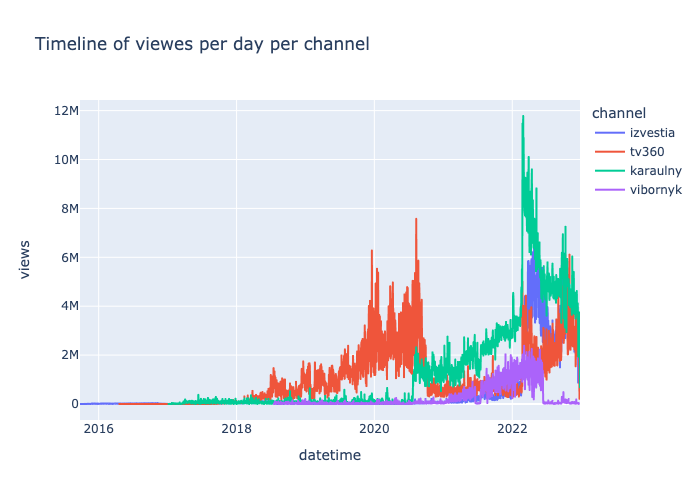

In [28]:
_df = df.groupby([df.datetime.dt.strftime('%Y-%m-%d'), 'channel'])['views'].sum().reset_index()
_df = _df[(_df['views']>0) & (_df.channel.isin(['izvestia', 'tv360', 'karaulny', 'vibornyk']))]

fig = px.line(_df, x="datetime", y="views", color='channel', log_y=False, title='Timeline of viewes per day per channel')
fig.show()

The iteresting observation here is that number of views for some channel increased for some period of time without correlation on other channels. This could be a reason of artificial viewes boosting. One of the example is bbbreaking channel with bump on April 2020.

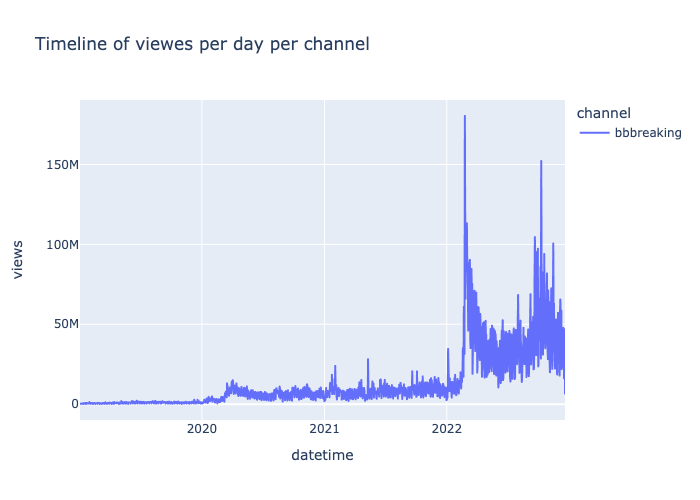

In [29]:
_df = df.groupby([df.datetime.dt.strftime('%Y-%m-%d'), 'channel'])['views'].sum().reset_index()
_df = _df[(_df['views']>0) & (_df['channel'] == 'bbbreaking')]

fig = px.line(_df, x="datetime", y="views", color='channel', log_y=False, title='Timeline of viewes per day per channel')
fig.show()

## Distribution of message length (in characters)

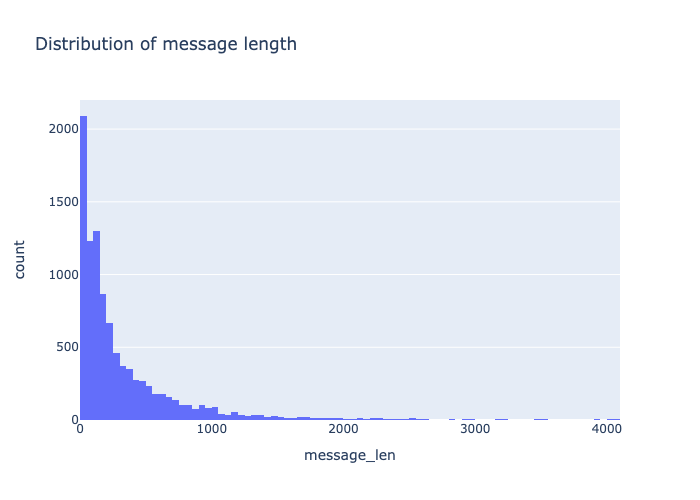

In [30]:
fig = px.histogram(df.sample(10000), x="message_len", title='Distribution of message length')
fig.show()

Observations:

The mode for message length is ~110 characters.

It seems there are a lot of empty messages. Let's check what thay are.

In [31]:
df[df.message_len == 0].sample(5)

Unnamed: 0       id                       date    views reactions  \
2666280       11560  24624.0  2021-09-19 08:23:49+00:00  51204.0       NaN   
7988981        6689  12005.0  2022-06-21 20:15:31+00:00   7147.0       NaN   
5014656       10925  12684.0  2021-11-16 15:57:32+00:00   2612.0       NaN   
5439075        3876   1333.0  2020-02-03 19:09:37+00:00      9.0       NaN   
7964087         141    622.0  2022-10-20 15:20:58+00:00  20300.0       NaN   

                                      to_id  \
2666280  PeerChannel(channel_id=1100118939)   
7988981  PeerChannel(channel_id=1465354533)   
5014656  PeerChannel(channel_id=1099737840)   
5439075  PeerChannel(channel_id=1255929553)   
7964087  PeerChannel(channel_id=1519103464)   

                                                                                                    fwd_from  \
2666280                                                                                                  NaN   
7988981                                                                                                  NaN   
5014656  MessageFwdHeader(date=datetime.datetime(2021, 11, 15, 18, 57, 20, tzinfo=datetime.timezone.utc),...   
5439075  MessageFwdHeader(date=datetime.datetime(2020, 2, 3, 15, 30, 20, tzinfo=datetime.timezone.utc), i...   
7964087                                                                                                  NaN   

        message   type  duration  ... msg_entity                  datetime  \
2666280     NaN  photo       NaN  ...        NaN 2021-09-19 08:23:49+00:00   
7988981     NaN  photo       NaN  ...        NaN 2022-06-21 20:15:31+00:00   
5014656     NaN  photo       NaN  ...        NaN 2021-11-16 15:57:32+00:00   
5439075     NaN  photo       NaN  ...        NaN 2020-02-03 19:09:37+00:00   
7964087     NaN  photo       NaN  ...        NaN 2022-10-20 15:20:58+00:00   

        message_len reactions_dict reactions_num      _from_id      _to_id  \
2666280           0             []             0           NaN  1100118939   
7988981           0             []             0           NaN  1465354533   
5014656           0             []             0  1.355541e+09  1099737840   
5439075           0             []             0  1.203105e+09  1255929553   
7964087           0             []             0           NaN  1519103464   

         sensitive-topic  toxicity      mid  
2666280             none   neutral  2666280  
7988981             none   neutral  7988981  
5014656             none   neutral  5014656  
5439075             none   neutral  5439075  
7964087             none   neutral  7964087  

[5 rows x 23 columns]

The sample returns messages that contains only photos.

Also there are very long messages with more than 4k characters.

In [32]:
df[df.message_len >4000].sample(5)

Unnamed: 0       id                       date    views  \
6165087         732  49099.0  2022-10-29 08:47:06+00:00  70854.0   
8045995        5060    830.0  2020-01-28 12:17:18+00:00    611.0   
5258078        3209   4890.0  2022-01-08 03:51:02+00:00   9832.0   
5508541       22713  13795.0  2022-04-27 11:10:57+00:00   4292.0   
6166122        1767  48047.0  2022-08-23 16:42:06+00:00  78682.0   

                                                                                                   reactions  \
6165087                                                                                                  NaN   
8045995                                                                                                  NaN   
5258078  MessageReactions(results=[ReactionCount(reaction='👍', count=161, chosen=False), ReactionCount(re...   
5508541  MessageReactions(results=[ReactionCount(reaction='👍', count=205, chosen=False), ReactionCount(re...   
6166122                                                                                                  NaN   

                                      to_id  \
6165087  PeerChannel(channel_id=1096463945)   
8045995  PeerChannel(channel_id=1272953589)   
5258078  PeerChannel(channel_id=1136444638)   
5508541  PeerChannel(channel_id=1296355218)   
6166122  PeerChannel(channel_id=1096463945)   

                                                                                                    fwd_from  \
6165087                                                                                                  NaN   
8045995                                                                                                  NaN   
5258078                                                                                                  NaN   
5508541  MessageFwdHeader(date=datetime.datetime(2022, 4, 27, 11, 3, 28, tzinfo=datetime.timezone.utc), i...   
6166122                                                                                                  NaN   

                                                                                                     message  \
6165087  Мнение экспертов. Генеральный директор «Petrova 5 Consulting» Марина Петрова – о влиянии санкций...   
8045995  Telega регионального здравоохранения\n\nПро медицину, медиков, пациентов. (мне пишут)\n\nДрузья,...   
5258078  Вообще евразийство и национал-большевизм в России придумал не Дугин, а белый офицер Николай Устр...   
5508541  Дорогие друзья, нам периодически шлют в обратку: «А вот вы пишите, что русские классные, а вот я...   
6166122  Мнение экспертов. Генеральный директор коммуникационного агентства Actor Дмитрий Еловский – о ме...   

         type  duration  ... msg_entity                  datetime message_len  \
6165087  text       NaN  ...        NaN 2022-10-29 08:47:06+00:00        4085   
8045995  text       NaN  ...        NaN 2020-01-28 12:17:18+00:00        4095   
5258078  text       NaN  ...        NaN 2022-01-08 03:51:02+00:00        4016   
5508541  text       NaN  ...        NaN 2022-04-27 11:10:57+00:00        4072   
6166122  text       NaN  ...        NaN 2022-08-23 16:42:06+00:00        4016   

                                                                                              reactions_dict  \
6165087                                                                                                   []   
8045995                                                                                                   []   
5258078  [{'reaction': '👍', 'count': 161, 'chosen': False}, {'reaction': '🔥', 'count': 22, 'chosen': Fals...   
5508541  [{'reaction': '👍', 'count': 205, 'chosen': False}, {'reaction': '❤', 'count': 23, 'chosen': Fals...   
6166122                                                                                                   []   

        reactions_num      _from_id      _to_id  sensitive-topic  toxicity  \
6165087             0           NaN  1096463945             

Few very long messages came from the different persons, who, I believe, are blogger who posts stories.

One of the assumption we can check - the long messages more likely contains propaganda.

### Analyze reactions distribution in dataset

In [33]:
# Miss rate for the reactions column is 

df.reactions.isna().sum() / len(df)

0.7655677678264549

In [34]:
_df = df[~df.reactions.isna()][['datetime', 'channel', 'reactions_dict', 'mid']]

_df = _df.explode('reactions_dict')

for col in ['reaction', 'count']:
    _df['_' + col] = _df['reactions_dict'].map(lambda x: x[col] if isinstance(x, dict) else None)

_df.drop(columns=['reactions_dict'], inplace=True) 
_df.sample()

datetime      channel      mid _reaction  _count
5941005 2022-11-29 06:30:03+00:00  foxandraven  5941005         😁   137.0

In [37]:
_df._reaction.unique()

array(['👍', '👏', '😁', '🤡', '👎', '❤', '🤔', '🤬', '🤯', '🔥', '😢', '🙏', '😱',
       '😭', '🎉', '⚡', '🥴', '💔', '😍', '🤣', '🥰', '👌', '🤨', '❤\\u200d🔥', '🤩',
       '💯', '😒', '😳', '💩', '🕊', '🤮', '🖕', '🌚', '🍾', '😐', '😈', '🥱', '🐳',
       '🍌', '💋', '🏆', '🌭', '🍓', '👀', '👻', '🙈', '\\U0001fae1', '🤝', '😴',
       '😨', '👨\\u200d💻', '🤗', '😇', '🎃', '🤓', '✍', '😂'], dtype=object)

In [50]:
_df = _df[~_df._reaction.isna() & ~_df._count.isna()]
__df = _df.groupby([_df.datetime.dt.strftime('%Y-%m-%d'), '_reaction'])['_count'].sum().reset_index()

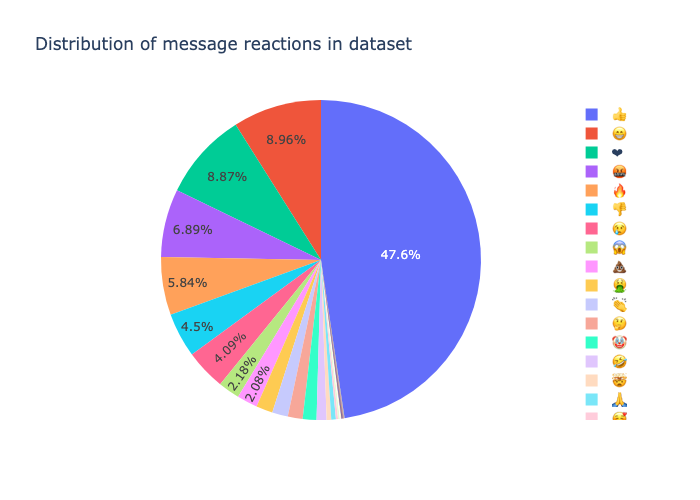

In [51]:
fig = px.pie(__df.groupby('_reaction').sum().reset_index(), names='_reaction', values='_count', title='Distribution of message reactions in dataset')
fig.update_traces(textposition='inside')
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')

fig.show()

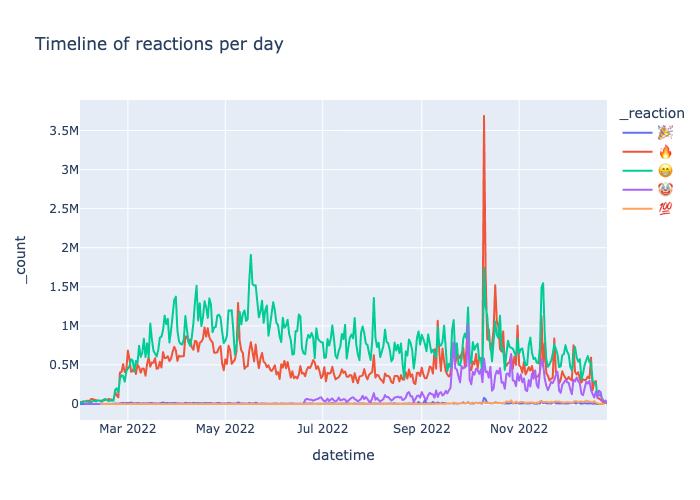

In [57]:
fig = px.line(__df[__df._reaction.isin(['😁', '🤡', '🔥', '💯', '🎉'])].tail(1500), x="datetime", y="_count", color='_reaction', log_y=False, title='Timeline of reactions per day')

fig.show()

Observations:
    
- The most used emoji is thumbsup (47%). The next common emojis are lol and heart (~8%)
- Fire emoji has two peaks: Sep 30 and Oct 10 2022
- The fire emoji also has significant bump Oct 10
- clown emoji has a couple bumps: The most signifficant Sep 30, Sep 21, Oct 27, Nov 15. The trend was significantly increase starting from Sep 21 and has decreasing trend
- angry emoji was used mostly Oct 8
- emoji 100% seems to have linear trend starting from Sep 11 2022 and continue to grow...
- tada emoji has several bumps that matches with clown 

In [128]:
_df = df[df.reactions_num>0].groupby([df.datetime.dt.strftime('%Y-%m-%d'), 'channel'])['reactions_num'].sum().reset_index()
# .tail(200000)
fig = px.line(_df, x="datetime", y="reactions_num", color='channel', log_y=False, title='Timeline of reactions number on news per channel per day', category_orders={'channel': np.sort(_df['channel'].unique())})
fig.update_traces(visible="legendonly", selector=lambda t: t.name not in ['SolovievLive', 'varlamov_news', 'bbbreaking', 'meduzalive']) # ,'bbbreaking', 'meduzalive'

fig.show()

According to the plot we see a set of bumps in views and number of reactions:

- 23 Jan 2021 (medusalive, bbbreaking): Protests in Russia in support of the opposition leader Alexei Navalny https://en.wikipedia.org/wiki/2021_Russian_protests
- 9  May 2021 (soloviev) victory in 2nd WW day bosted with propaganda about new war with fascism
- 11 May 2021 (medusa, breakingmash): a school shooting occurred in Kazan https://en.wikipedia.org/wiki/Kazan_school_shooting
- 5 Jan 2022: Russia released plans for new wave of mobilisation: https://www.pravda.com.ua/eng/news/2022/12/30/7383028/
- 21-28 Feb 2022: Full scale invasion
- 21 Sep 2022: Russia declared a partial mobilization of military reservists  https://en.wikipedia.org/wiki/2022_Russian_mobilization
- 10 Oct 2022: Massive missile attack on Ukraine infrastructure supported with high level of propaganda and disinformation https://www.wilsoncenter.org/blog-post/ukraine-quarterly-digest-october-december-2022
- 15 Nov 2022: Massive missile attack on Ukraine infrastructure

The number of reactions contains expressive bumps comparing to views, let's check the engaging ratio

### Engagement ratios

To get better understanding of user's behavoiur let's introduce engagement ratios: 
- engaging_views: ratio of reactions num per number of views.
- engaging_posts: ratio of reactions number per number of posts for each group
- viewed_ratio: ratio of viewes number per number of posts

Let's check separately number of viewes for specific emojis as well.

In [107]:
_df1 = df.groupby('channel')['views'].sum().reset_index().sort_values('channel', ascending=False)
_df2 = df.groupby('channel')['reactions_num'].sum().reset_index().sort_values('channel', ascending=False)
_df3 = df.groupby('channel')['id'].count().reset_index().sort_values('channel', ascending=False).rename(columns={'id': 'posts_num'})

_df = pd.merge(_df1, _df2,  how='left', left_on=['channel'], right_on = ['channel'])
_df = pd.merge(_df, _df3,  how='left', left_on=['channel'], right_on = ['channel'])

_df['engaging_posts'] = _df['reactions_num'] / _df['posts_num']
_df['engaging_views'] = _df['reactions_num'] / _df['views']
_df['viewed_ratio'] = _df['views'] / _df['posts_num']

_df.sample()

channel        views  reactions_num  posts_num  engaging_posts  \
198  holmogortalks  186701480.0        2762566      25936      106.514729   

     engaging_views  viewed_ratio  
198        0.014797   7198.545651

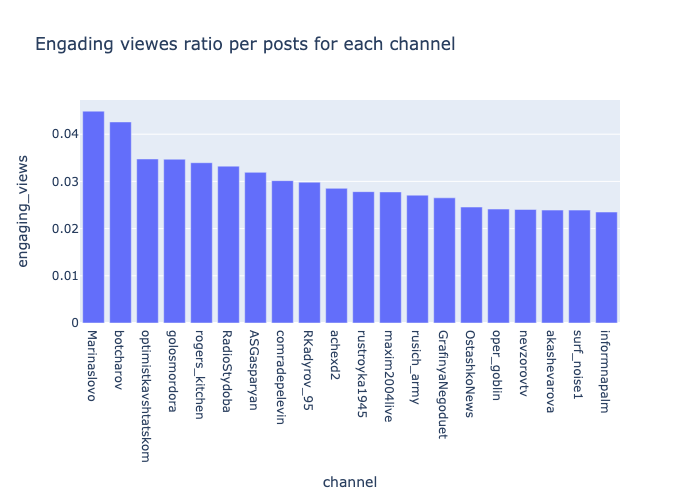

In [108]:
fig = px.bar(_df.sort_values('engaging_views', ascending=False).head(20), x='channel', y='engaging_views', title='Engading viewes ratio per posts for each channel')
fig.show()

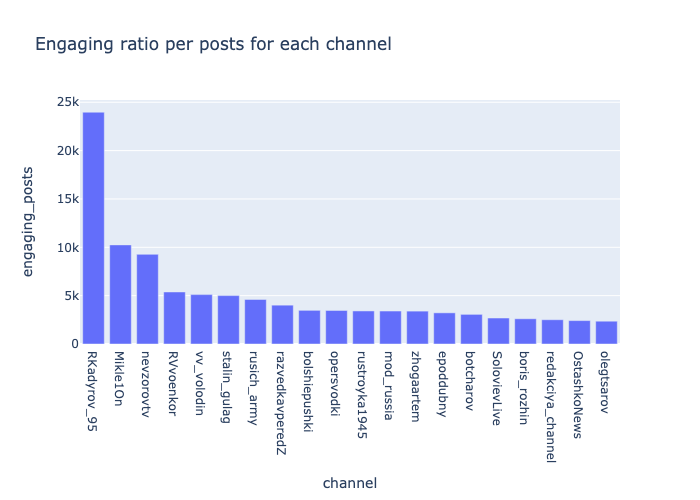

In [109]:
fig = px.bar(_df.sort_values('engaging_posts', ascending=False).head(20), x='channel', y='engaging_posts', title='Engaging ratio per posts for each channel')
fig.show()

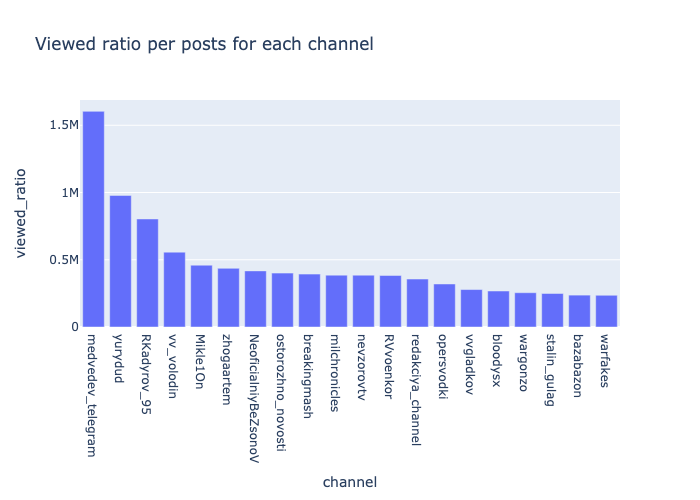

In [110]:
fig = px.bar(_df.sort_values('viewed_ratio', ascending=False).head(20), x='channel', y='viewed_ratio', title='Viewed ratio per posts for each channel')
fig.show()

We see the most engaged channels in terms of number of reactions per number of viewes related to private (non news channels), like:
- marinaslovo (4%)
- botcharov (4%)

In this case rkadyrov also is in top 10 engaged channels.
Glavmedia has emgagement ratio of 0.5%.

The most engaged channel in terms of number of reaction number per posts is rkadyrov, then mikle1on. 

The most viewed channel is medvedev, yurydud and rkadyrov.


In all 3 groups rkadyrov is in top engaged channels, so a well-deserved name is "tik-tok troop".

In [129]:
_df1 = df.groupby([df.datetime.dt.strftime('%Y-%m-%d'), 'channel'])['views'].sum().reset_index()
_df2 = df.groupby([df.datetime.dt.strftime('%Y-%m-%d'), 'channel'])['reactions_num'].sum().reset_index()

_df = pd.merge(_df1, _df2,  how='left', left_on=['datetime', 'channel'], right_on = ['datetime', 'channel'])
_df = _df[_df['views']>0]

_df['engaging_views'] = _df['reactions_num'] / _df['views']


In [130]:
fig = px.line(_df, x="datetime", y="engaging_views", log_y=False, title='Timeline of engaging viewes ratio on news per day')
fig.show()

In [133]:
fig = px.line(_df[_df.channel.isin(['umar_kremlev', 'Mikle1On', 'SolovievLive', 'epoddubny'])], x="datetime", y="engaging_views", color='channel', 
              log_y=False, title='Timeline of engaging ratio on news per channel per day',
              category_orders={'channel': np.sort(_df['channel'].unique())})
fig.show()


We see significant engagement bumps are for epodduny at Aug 2018, May 2019.

Let's dive into period for full-scale invasion and checks engaments per each channel

In [132]:
fig = px.line(_df[_df.channel.isin(['umar_kremlev', 'Mikle1On', 'SolovievLive'])], x="datetime", y="engaging_views", color='channel', log_y=False, title='Timeline of engaging ratio on news per channel per day', category_orders={'channel': np.sort(_df['channel'].unique())})
fig.show()


We can see some interesting trends:
- umar_kremlev has inreased engamement at the beginning of channel existence
- kadyrov and mikle1on has similar and mostly constant engamenet starting from march 2022

### General distribution of messages between sensitive topics

Paper with description of topics presented here.

https://arxiv.org/pdf/2103.05345.pdf

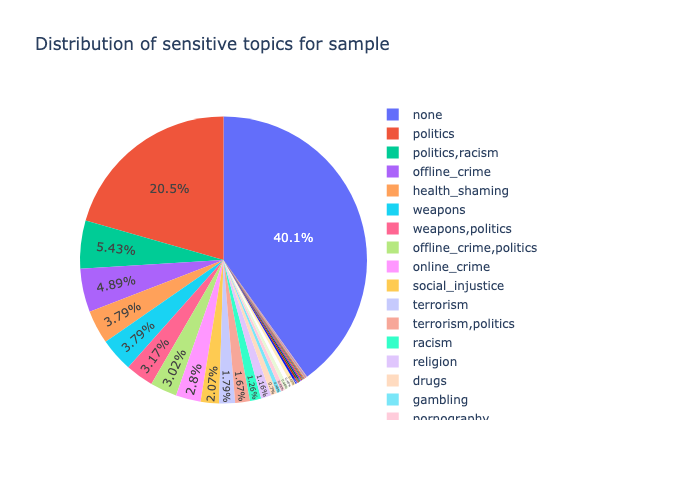

In [115]:
fig = px.pie(df.sample(10000), names='sensitive-topic', title='Distribution of sensitive topics for sample')
fig.update_traces(textposition='inside')

# fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.show() # renderer='notebook'

The most common topic is politics.

Next general most common topics are: weapons, online/offline crime, health_shaming, rasims, social injustice.

Unexpected? no!

Let's check the main directions for each channel (remove none and politics as most commonly used topics)

In [142]:
_df_sensitive = df[df["sensitive-topic"] != 'none']

_df_count = _df_sensitive.value_counts(['channel']).reset_index()
_df = _df_sensitive.value_counts(['channel', 'sensitive-topic']).reset_index()

fig = px.bar(_df[_df["sensitive-topic"].isin(['terrorism', 'weapons', 'religion', 'health_shaming'])].sort_values('count', ascending=False), x="channel", y="count", color="sensitive-topic", title="Distribution of topics for each channel")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

In [144]:
for name, row in _df_count.iterrows():
    _df.loc[_df['channel'] == row['channel'] , 'count_norm'] = _df.loc[_df['channel'] == row['channel'] , 'count'] / row['count']

fig = px.bar(_df[_df["sensitive-topic"].isin(['politics', 'terrorism', 'weapons', 'religion', 'health_shaming', 'racism', 'social_injustice'])], x="channel", y="count_norm", color="sensitive-topic", title="Normalized distribution of topics for each channel")
fig.update_layout(barmode='stack', xaxis={'categoryorder':'total descending'})
fig.show()

Sensitive topics classification allows to classify channels direction, for example
- milinfolive and infantomilitario the channel is about weapons
- mnews_ru 73% of content has about health shaming
- criminalru and ikakprosto are about online crime  for 47% and 21% about offline crimes
- umar kremlev has 25% of religion content? the next in top religion channel is sorok40russia
- chdambiev and razvedosaa posts mostly about weapons (50 and 60% respectively)
- the most rasism channel is mnogoznai
- top gamling channel is n_zackhaim, tikandelaki
- maxim2004live posted about drugs the most

Let's check how general topics distriuted in time.

In [136]:
_df = _df_sensitive.groupby([_df_sensitive['datetime'].dt.strftime('%Y-%m-%d'), 'sensitive-topic'])['views'].count().reset_index()

fig = px.line(_df, x="datetime", y="views", color='sensitive-topic', log_y=False, title='Timeline of sensitive topics count per day')
fig.show()

In [137]:
_df = _df_sensitive.groupby([_df_sensitive['datetime'].dt.strftime('%Y-%m-%d'), 'sensitive-topic'])['views'].sum().reset_index()

fig = px.line(_df, x="datetime", y="views", color='sensitive-topic', log_y=False, title='Timeline of sensitive topics viewes sum per day')
fig.show()


Observations:

- April 2018 - Russian intervention in the Syrian civil war

- health shaming news broadcasted April 2020, this is mostly because of Convid-19 quarantine, so people started working from home and do not move lot.

- the bump of number of political news happend 24 Feb 2022. Also there are some other bumps: 
    - May 9 2022
    - June 17 2022, Russia will use nuclear weapons if its sovereignty is threatened - Putin (https://www.pravda.com.ua/eng/news/2022/06/17/7353142/)
    - Sep 21 2022, Russia annonsed plans for mobilisation
- Number of political news has seasonality for 7 days with peak on Thursday
- The bump for number of religion news was 23-24 April - ortodox Easter, and 2 Dec 2022 - nationalisation of Kyiv Pechersk Lavra
- The most viewed news about weapons was Oct 8 - Oct 11 2022, Crimea bridge destuction, haha. We also see posts about terrorism started earlier and after continue with bump for weapons topic.
- The second most viewed weapon posts was at Nov 13 2022, nothing special in news but still a bump...
- An interesting fact - reactions started collecting from Feb 24 2022

## Graph analysis

The following section analyze the importance of the reposts network for given data and topics analysis. Importance is calculated with PageRank alogithm. 

To reduce number of arcs and nodes and selects only extreme values we use graph pruning and nodes filtering according to the importance and number of arcs that connects channels by repost news.


In [170]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.offline import iplot
from nxviz import CircosPlot

In [171]:
### Considering node importance

G = nx.DiGraph()

_df_topic = _df_sensitive[~(_df_sensitive._from_id.isna() | _df_sensitive._to_id.isna())]
_df_topic['_to_id'] = _df_topic['_to_id'].astype(np.int32)
_df_topic['_from_id'] = _df_topic['_from_id'].astype(np.int32)

for name, group in _df_topic.groupby(['channel', '_to_id']):
    G.add_node(int(name[1]))

for idx, group in _df_topic.groupby(['_from_id', '_to_id']):
    G.add_edge(int(idx[0]), int(idx[1]))

pr = nx.pagerank(G, alpha=0.85)

In [172]:
pr_threshold = np.quantile(list(pr.values()), 0.99)
pr_threshold

0.0013047728686883448

In [173]:
col_list = ['lightgray',
           'red',
           'goldenrod',
           'firebrick',
           'springgreen',
           'blue',
           'slateblue',
           'khaki',
           'azure',
           'limegreen',
           'green',
           'salmon',
           'darkblue',
           'skyblue',
           'violet',
           'pink',
           'sienna',
           'palegreen',
           'darkcyan',
           'orchid',
           'cadetblue',
           'magenta',
           'slategrey',
           'olive',
           'lightgrey',
           'royalblue',
           'indigo',
           'blueviolet',
           'gold',
           'aquamarine',
           'lightcoral',
           'teal',
           'fuchsia',
           '#03f5dd']

topics_list = _df_sensitive["sensitive-topic"].unique().tolist()

G = nx.DiGraph()

_df_topic = _df_sensitive[~(_df_sensitive._from_id.isna() | _df_sensitive._to_id.isna())]
_df_topic['_to_id'] = _df_topic['_to_id'].astype(np.int32)
_df_topic['_from_id'] = _df_topic['_from_id'].astype(np.int32)

nodes = {}
nodes_count = {}
for name, group in _df_topic.groupby(['channel', '_to_id']):
    if pr[name[1]] < pr_threshold:
        continue
    top_topic = group["sensitive-topic"].value_counts().reset_index().sort_values('count', ascending=False).to_dict('records')[0]
    nodes[name[1]] = name[0]
    nodes_count[name[1]] = top_topic['count']
    G.add_node(
        int(name[1]), 
        label=f'[{top_topic["sensitive-topic"]}] {name[0]}',
        group=top_topic["sensitive-topic"],
        color=col_list[topics_list.index(top_topic["sensitive-topic"])],
        value=10*pr[name[1]] / max(pr.values())
    )

for idx, group in _df_topic.groupby(['_from_id', '_to_id']):
    if idx[0] not in nodes or idx[1] not in nodes:
        continue
    w = len(group) / nodes_count[idx[1]]
    if w < 0.15:
        continue
    G.add_edge(int(idx[0]), int(idx[1]), weight=w)

In [174]:
from pyvis.network import Network

net = Network(notebook=True, directed=True)

net.from_nx(G)
net.show_buttons(filter_=['physics'])
net.show(f'nx-topic-top-colored.html')

nx-topic-top-colored.html


The extremely 1% most important nodes forms the network about politics.

PageRank algorithm selects as most important nodes:
- karaulny
- glavmedia

We also see separated clusters of news groups with same topics:
- offline_cime criminalru and chhkogpu 
- politics: kstati_p, otsika_bld ctrs2019 and rastriga
- rasstrelny and rlz_the_kraken
- skvir (about drugs), bogemasranaya (politics) gori_spb (online crime) thynk (body shaming) impnotbozhena (politics)


rt_russian, bbbreaking, sashakots seems used mostly as a sources of news for different other nodes, but is not considered as important.
                                                

### Analyze engamenent for the graph

Let's check the distribution of the engagement ratio for this research and find outliers. 

Then let's plot connection in graph for abnormally reacted messages.

In [188]:
_df_topic = _df_sensitive[~(_df_sensitive._from_id.isna() | _df_sensitive._to_id.isna())]
_df_topic['_to_id'] = _df_topic['_to_id'].astype(np.int32)
_df_topic['_from_id'] = _df_topic['_from_id'].astype(np.int32)

nodes = {}
for name, group in _df_topic.groupby(['channel', '_to_id']):
    nodes[name[1]] = name[0]

_df_topic = _df_topic[_df_topic['_from_id'].isin(nodes) & _df_topic['_to_id'].isin(nodes)]
_df_topic['engagement'] = _df_topic['reactions_num'] / _df_topic['views']


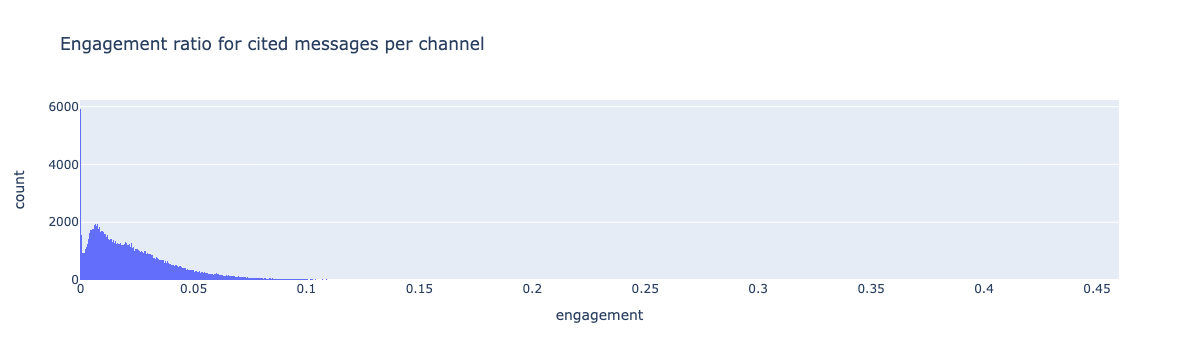

In [189]:
_df = _df_topic[(_df_topic['engagement']>0.000001)&(_df_topic['views']>1000)]
fig = px.histogram(_df, x='engagement', title='Engagement ratio for cited messages per channel')

fig.show()

It seems the engagement ratio has log-normal distribution but with small bump at 0.02. Let's find channels with distribution that is not log-normal by using Kolmogorov-Smirnov test.

In [190]:
import scipy
import scipy.stats

def check_if_lognorm(data):
    pvalue = scipy.stats.kstest(data, "lognorm", scipy.stats.lognorm.fit(data)).pvalue
    if pvalue < 0.05:
        return False
    return True

abnormal_groups = []

for name, group in _df.groupby('channel'):
    if not check_if_lognorm(group['engagement'].values):
        abnormal_groups.append(name)

In [191]:
abnormal_groups

['Hinshtein',
 'Mikle1On',
 'NeoficialniyBeZsonoV',
 'Postovo',
 'RVvoenkor',
 'RtrDonetsk',
 'SergeyKolyasnikov',
 'Sladkov_plus',
 'SolovievLive',
 'Topaz_Govorit',
 'anna_news',
 'archivarius_dz',
 'boris_rozhin',
 'dimsmirnov175',
 'ebobo_rus',
 'epoddubny',
 'glavmedia',
 'golosmordora',
 'gramotyyaroslava',
 'kornilov1968',
 'ksbchk',
 'kshulika',
 'kstati_p',
 'minaevlife',
 'mozhemobyasnit',
 'navideovidno',
 'norin_ea',
 'obyasnayemrf',
 'opersvodki',
 'otsuka_bld',
 'parfentiev_club',
 'rasstrelny',
 'razvedosaa',
 'redakciya_channel',
 'rosich_ru',
 'rt_russian',
 'rusbrief',
 'russ_orientalist',
 'rusvesnasu',
 'sashakon',
 'sashakots',
 'sskarnaukhov',
 'strelkovii',
 'surf_noise1',
 'swodki',
 'tikandelaki',
 'varlamov',
 'varlamov_news',
 'voenacher',
 'voenkorKotenok',
 'warfakes',
 'wargonzo']

In this list we see rt_russian, rkadyrov and others channels with high level of viewes or engagement.

Let's build this network and investigate connections between channels.

In [192]:
import warnings
warnings.filterwarnings("ignore")

In [195]:
_df_topic = _df_sensitive[~(_df_sensitive._from_id.isna() | _df_sensitive._to_id.isna())&(_df_topic['channel'].isin(abnormal_groups))]
_df_topic['_to_id'] = _df_topic['_to_id'].astype(np.int32)
_df_topic['_from_id'] = _df_topic['_from_id'].astype(np.int32)

_df_topic['engagement'] = _df_topic['reactions_num'] / _df_topic['views']

_df_topic = _df_topic[(_df_topic['engagement']>0.001)&(_df_topic['views']>100)]

nodes = {}
for name, group in _df_topic.groupby(['channel', '_to_id']):
    nodes[name[1]] = name[0]

_df_topic = _df_topic[_df_topic['_from_id'].isin(nodes) & _df_topic['_to_id'].isin(nodes)]

_df = _df_topic.groupby(['_from_id', '_to_id'])['reactions_num'].sum().reset_index().sort_values('reactions_num', ascending=False)
_df = _df[_df.reactions_num>_df['reactions_num'].quantile(0.5)]

G = nx.DiGraph()

for name, group in _df.groupby('_to_id'):
    G.add_node(
        int(name), 
        label=f'{nodes[name]}',
        value=pr[name] / max(pr.values())
    )

for idx, group in _df.groupby(['_from_id', '_to_id']):
    w = np.log10(group.reactions_num).values[0]
    if w < 5:
        continue
    G.add_edge(int(idx[0]), int(idx[1]), weight=w/3)

net = Network(notebook=True, directed=True)

net.from_nx(G)
net.show_buttons(filter_=['physics'])
net.show(f'nx-topic-pr-reactions-abnormal_engagement.html')


nx-topic-pr-reactions-abnormal_engagement.html


We see, soloviev boris rozhin, rvonekor, voenkomketenor are highly connected between each other.

Let's check distribution of cited messages only through the time

In [145]:
_df = _df_sensitive[~(_df_sensitive._from_id.isna() | _df_sensitive._to_id.isna())]

_df = _df.groupby([_df['datetime'].dt.strftime('%Y-%m-%d'), 'sensitive-topic'])['views'].count().reset_index()

fig = px.line(_df, x="datetime", y="views", color='sensitive-topic', log_y=False, title='Timeline of sensitive topics count per day for cited messages')
fig.show()

We see the significant increase fo messages about politics and weapons stating from 24 Feb 2022. Let's check the connection of channels at 24 Feb 2022.

Also let's recalculate node importance because it could be different from the general.

In [182]:
G = nx.DiGraph()

_df = _df_sensitive[
    ~(_df_sensitive._from_id.isna() | _df_sensitive._to_id.isna())
    &((_df_sensitive['datetime'] >= pd.to_datetime('2022-02-24 00:00:00+00:00')) & (_df_sensitive['datetime'] <= pd.to_datetime('2022-02-25 00:00:00+00:00')))]

for name, group in _df.groupby(['channel', '_to_id']):
    G.add_node(int(name[1]))

for idx, group in _df.groupby(['_from_id', '_to_id']):
    G.add_edge(int(idx[0]), int(idx[1]))

pr_24feb = nx.pagerank(G, alpha=0.85)


In [183]:
_df = _df_sensitive[
    ~(_df_sensitive._from_id.isna() | _df_sensitive._to_id.isna())
    &((_df_sensitive['datetime'] >= pd.to_datetime('2022-02-24 00:00:00+00:00')) & (_df_sensitive['datetime'] <= pd.to_datetime('2022-02-25 00:00:00+00:00')))]

nodes = {}
for name, group in _df.groupby(['channel', '_to_id']):
    nodes[name[1]] = name[0]

G = nx.DiGraph()

for name, group in _df.groupby('_to_id'):
    top_topic = group["sensitive-topic"].value_counts().reset_index().sort_values('count', ascending=False).to_dict('records')[0]
    G.add_node(
        int(name), 
        label=f'[{top_topic["sensitive-topic"]}] {nodes[name]}',
        value=pr_24feb[name] / max(pr_24feb.values()),
        color=col_list[topics_list.index(top_topic["sensitive-topic"])]
    )

for idx, group in _df.groupby(['_from_id', '_to_id']):
    if len(group) < 10:
        continue
    # w = np.log10(group.reactions_num).values[0]
    # if w < 3:
    #     continue
    G.add_edge(int(idx[0]), int(idx[1]))# , weight=w/3)

net = Network(notebook=True, directed=True)

net.from_nx(G)
net.show_buttons(filter_=['physics'])
net.show(f'nx-topic-pr-24Feb2022.html')

nx-topic-pr-24Feb2022.html


We see the most importrant according to PageRank node keeps the same - glavmedia. But in this distribution appeared other nodes like siloviki and truth aggregation with the main topic about politics.

# Conclusions

It was investigated russian propaganda dataset based on telegram channels.

- 84.1% of all messages contains text or photos. ~15.7% are mostly videos, other are stikers or voice messages.
- The most active channel is karaulny; glavmedia and other news channels have mostly the same number of messages for the investigated period from 2015-09-22 to 2022-12-26.
- There are a few abnormal number of messages per channel for 24 Feb 2022 from:
    - swodki
    - bosis rozhin
    - glavmedia
- glavmedia,  bosis rozhin considered as the most important channels during this day according to PageRank model
- The most viewed channel is rian_ru, the next is solovievlive and bbbreaking.
- The iteresting observation here is that number of views for mostly all channels increased starting from 24 Feb.
- Also it was discovered that some channels boosted popularity with number of viewes for some period of time without correlation on other channels. This could be a reason of artificial viewes boosting. One of the example is bbbreaking channel with bump on April 2020.

According to the time-dependency plots we see a set of bumps in views and number of reactions:

- 23 Jan 2021 (medusalive, bbbreaking): Protests in Russia in support of the opposition leader Alexei Navalny https://en.wikipedia.org/wiki/2021_Russian_protests
- 9  May 2021 (soloviev) victory in 2nd WW day bosted with propaganda about new war with fascism
- 11 May 2021 (medusa, breakingmash): a school shooting occurred in Kazan https://en.wikipedia.org/wiki/Kazan_school_shooting
- 5 Jan 2022: Russia released plans for new wave of mobilisation: https://www.pravda.com.ua/eng/news/2022/12/30/7383028/
- 21-28 Feb 2022: Full scale invasion
- 21 Sep 2022: Russia declared a partial mobilization of military reservists  https://en.wikipedia.org/wiki/2022_Russian_mobilization
- 10 Oct 2022: Massive missile attack on Ukraine infrastructure supported with high level of propaganda and disinformation https://www.wilsoncenter.org/blog-post/ukraine-quarterly-digest-october-december-2022
- 15 Nov 2022: Massive missile attack on Ukraine infrastructure

According to emojis analysis it was observed:
- The most used emoji is thumbsup (47%). The next common emojis are lol and heart (~8%)
- Fire emoji has two peaks: Sep 30 and Oct 10 2022 and significant bump at Oct 10
- Clown emoji has a couple bumps: The most signifficant Sep 30, Sep 21, Oct 27, Nov 15. The trend was significantly increase starting from Sep 21 and has decreasing trend
- angry emoji was used mostly Oct 8
- emoji 100% seems to have linear trend starting from Sep 11 2022 and continue to grow...
- tada emoji has several bumps that matches with clown


It was introduced a set of engagement ratios:
- engaging_views: ratio of reactions num per number of views.
- engaging_posts: ratio of reactions number per number of posts for each group
- viewed_ratio: ratio of viewes number per number of posts

Engaging ratios shows that rkadyrov is in top 10 engaged channels so a well-deserved name is "tik-tok troop".

The "normal" engagement (viewes) becomes a constant on the level of 0.5% reactions per viewes for Glavmedia channel.

Engagement allows to find outlier channels in engagement related to private (non news channels), like:
- marinaslovo (4%)
- botcharov (4%)

We can see some interesting trends:
- umar_kremlev has inreased engamement at the beginning of channel existence
- kadyrov and mikle1on has similar and mostly constant engamenet starting from march 2022

This research uses sensitive topics to get better understanding of the topics used in the propaganda news dataset.

It was discovered that:
- the most common topic is politics.
- Next general most common topics are: weapons, online/offline crime, health_shaming, rasims, social injustice.
- milinfolive and infantomilitario the channel is about weapons
- mnews_ru 73% of content has about health shaming
- criminalru and ikakprosto are about online crime  for 47% and 21% about offline crimes
- umar kremlev has 25% of religion content? the next in top religion channel is sorok40russia
- chdambiev and razvedosaa posts mostly about weapons (50 and 60% respectively)
- the most rasism channel is mnogoznai
- top gamling channel is n_zackhaim, tikandelaki
- maxim2004live posted about drugs the most
- bump for online crime at April 2018 shows Russian intervention in the Syrian civil war
- health shaming news broadcasted April 2020, this is mostly because of Convid-19 quarantine, so people started working from home and do not move lot.
- June 17 2022, Russia will use nuclear weapons if its sovereignty is threatened - Putin (https://www.pravda.com.ua/eng/news/2022/06/17/7353142/)
- Number of political news has seasonality for 7 days with peak on Thursday
- The bump for number of religion news was 23-24 April - ortodox Easter, and 2 Dec 2022 - nationalisation of Kyiv Pechersk Lavra
- The most viewed news about weapons was Oct 8 - Oct 11 2022, Crimea bridge destuction, haha. We also see posts about terrorism started earlier and after continue with bump for weapons topic.


According to the research of graph connections of news reposting between channels we see

- channels forms the clusters depending on topic:
    * offline_cime criminalru and chhkogpu 
    * politics: kstati_p, otsika_bld ctrs2019 and rastriga
    * rasstrelny and rlz_the_kraken
    * skvir (about drugs), bogemasranaya (politics) gori_spb (online crime) thynk (body shaming) impnotbozhena (politics)
- rt_russian, bbbreaking, sashakots seems used mostly as a sources of news for different other nodes, but is not considered as important.

We see the significant increase fo messages about politics and weapons stating from 24 Feb 2022. The most importrant according to PageRank node keeps the same - glavmedia. But in this distribution appeared other nodes like siloviki and truth_aggregation with the main topic about politics.
